# Reducing the Trotter error of Hamiltonian dynamics with multi-product formulas

In this notebook, you will learn how to use a **Multi-Product Formula (MPF)** to achieve a lower Trotter error on our observable compared to the one incurred by the deepest Trotter circuit that we will actually execute.
You will do so by working through the steps of a **Qiskit pattern**:

- **Step 1: Map to quantum problem**
    - Initialize our problem's Hamiltonian
    - <font color="#0F62FE">Use an MPF to generate the Trotterized time-evolution circuits</font>
- **Step 2: Optimize the problem**
    - Here we transpile our circuits for a [GenericBackendV2](https://docs.quantum.ibm.com/api/qiskit/qiskit.providers.fake_provider.GenericBackendV2)
- **Step 3: Execute experiments**
    - Use a [StatevectorEstimator](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorEstimator) for sake of simplicity in this notebook
- **Step 4: Reconstruct results**
    - <font color="#0F62FE">Compute the MPF expectation value</font>

## Step 1: Map to quantum problem

### 1a: Setting up our Hamiltonian

We use the Ising model on a line of 10 sites:

$$
\hat{\mathcal{H}}_{\text{Ising}} = \sum_{i=1}^{9} J_{i,(i+1)} Z_i Z_{(i+1)} + \sum_{i=1}^{10} h_i X_i \, ,
$$

where $J$ is the coupling strength between two sites and $h$ is the external magnetic field.

The [qiskit_addon_utils](https://qiskit.github.io/qiskit-addon-utils/) package provides some reusable functionalities for various purposes.

Its [qiskit_addon_utils.problem_generators](https://qiskit.github.io/qiskit-addon-utils/stubs/qiskit_addon_utils.problem_generators.html) module provides functions to generate Heisenberg-like Hamiltonians on a given connectivity graph.
This graph can be either a [rustworkx.PyGraph](https://www.rustworkx.org/apiref/rustworkx.PyGraph.html) or a [CouplingMap](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.CouplingMap) making it easy to use in Qiskit-centric workflows.

In the following, we create a simple line of 10 qubits using the `CouplingMap.from_line` method.

In [1]:
from qiskit.transpiler import CouplingMap

# Generate some coupling map to use for this example
coupling_map = CouplingMap.from_line(10, bidirectional=False)

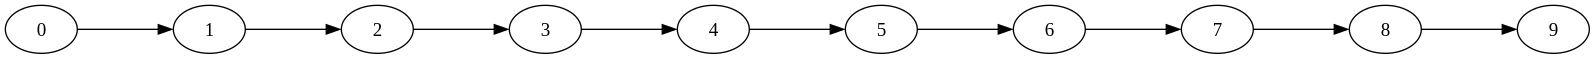

In [2]:
from rustworkx.visualization import graphviz_draw

graphviz_draw(coupling_map.graph, method="circo")

Next, we generate the [SparsePauliOp](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp) on the provided connectivity with the desired constants.

In [3]:
from qiskit_addon_utils.problem_generators import generate_xyz_hamiltonian

# Get a qubit operator describing the Ising field model
hamiltonian = generate_xyz_hamiltonian(
    coupling_map,
    coupling_constants=(0.0, 0.0, 1.0),
    ext_magnetic_field=(0.4, 0.0, 0.0),
)
print(hamiltonian)

SparsePauliOp(['IIIIIIIZZI', 'IIIIIZZIII', 'IIIZZIIIII', 'IZZIIIIIII', 'IIIIIIIIZZ', 'IIIIIIZZII', 'IIIIZZIIII', 'IIZZIIIIII', 'ZZIIIIIIII', 'IIIIIIIIIX', 'IIIIIIIIXI', 'IIIIIIIXII', 'IIIIIIXIII', 'IIIIIXIIII', 'IIIIXIIIII', 'IIIXIIIIII', 'IIXIIIIIII', 'IXIIIIIIII', 'XIIIIIIIII'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j,
 1. +0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j,
 0.4+0.j, 0.4+0.j, 0.4+0.j])


The observable that we will be measuring is the total magnetization which we can simply construct as shown below:

In [4]:
from qiskit.quantum_info import SparsePauliOp

L = coupling_map.size()
observable = SparsePauliOp.from_sparse_list([("Z", [i], 1 / L / 2) for i in range(L)], num_qubits=L)
print(observable)

SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII'],
              coeffs=[0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j,
 0.05+0.j, 0.05+0.j, 0.05+0.j])


### 1b: Multi-Product Formulas

MPFs reduce the Trotter error of Hamiltonian dynamics through a weighted combination of several circuit executions.

To make this more concrete, we define an MPF as:

$$
\mu(t) = \sum_{j} x_j \rho^{k_j}_{j}\left(\frac{t}{k_j}\right) + \text{some remaining Trotter error} \, ,
$$

where $x_j$ are our weighting coefficients, $\rho^{k_j}_j$ is the density matrix corresponding to the pure state obtained by evolving the initial state with the product formula, $S^{k_j}$, involving $k_j$ Trotter steps, and $j$ indexes the number of PFs that make up the MPF.

The key here is that the remaining Trotter error is smaller than the Trotter error that one would obtain by simply using the largest $k_j$ value!

You can view the usefulness of MPF from two perspectives:

1. For a fixed budget of Trotter steps that you are able to execute, you can obtain results with a Trotter error that is smaller in total.
2. For a number of Trotter steps which results in deep circuits, you can use MPF to find several shorter-depth circuits to run which result in a similar Trotter error.

#### An introduction to static MPFs

_Static_ MPFs are those where the $x_j$ values do **NOT** depend on the evolution time, $t$.

Determining the static MPF coefficients for a given set of $k_j$ values amounts to solving a linear system of equations:
$Ax=b$, where $x$ are our coefficients of interest, $A$ is a matrix depending on $k_j$ and the type of PF we use ($S$), and $b$ is a vector of constraints.
For brevity, we are not going to go into more detail here and instead refer you to the documentation of [LSE](https://qiskit.github.io/qiskit-addon-mpf/stubs/qiskit_addon_mpf.costs.LSE.html).

We can find a solution for $x$ analytically as $x = A^{-1}b$, see e.g. [Carrera Vazquez et al., 2023] or [Zhuk et al., 2023].
However, this exact solution can be _"ill-conditioned"_ resulting in very large L1-norms of our coefficients, $x$, which can lead to bad performance of the MPF.
Instead, one can also obtain an approximate solution which minimizes the L1-norm of $x$ in order to attempt and optimize the MPF behavior.

In the following, you will learn how to do all of this.

[Carrera Vazquez et al., 2023]: https://quantum-journal.org/papers/q-2023-07-25-1067/
[Zhuk et al., 2023]: https://arxiv.org/abs/2306.12569

#### Choosing $k_j$

The choice of $k_j$ is up to the end-user.
In principle, any values can be chosen but some $k_j$'s will lead to a larger noise amplification on real devices than other choices.
Thus, it is important that one tries to find _"good"_ values of $k_j$.

Here, we will simply pick some fixed values for $k_j$.
The smallest value is motivated by the target evolution time of $t=8.0$ which normally tells us to satisfy $t/k_{\text{min}} \lt 1$ but empirically we know that setting it equal to $1$ usually works, too.
If you want to learn more about this and how to choose your other $k_j$ values, refer to the respective guide: [How to choose the Trotter steps for an MPF](https://qiskit.github.io/qiskit-addon-mpf/how_tos/choose_trotter_steps.html).

In [5]:
time = 8.0
trotter_steps = (8, 12, 19)

#### Setting up the LSE

Now that we have chosen our $k_j$s, we must first construct the LSE, $Ax=b$ as explained above.
The matrix $A$ depends not only on $k_j$ but also our choice of product formula (PF) -- in particular its _order_.
Additionally, one may take into account whether the PF is symmetric or not (see [Carrera Vazquez et al., 2023]), by setting `symmetric=True`.
However, this is not required as shown by [Zhuk et al., 2023].

Here, we are going to use a second-order Suzuki-Trotter formula yielding `order=2` and we will set `symmetric=True`.

[Carrera Vazquez et al., 2023]: https://quantum-journal.org/papers/q-2023-07-25-1067/
[Zhuk et al., 2023]: https://arxiv.org/abs/2306.12569

In [6]:
from qiskit_addon_mpf.static import setup_static_lse

lse = setup_static_lse(trotter_steps, order=2, symmetric=True)
print(lse)

LSE(A=array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.56250000e-02, 6.94444444e-03, 2.77008310e-03],
       [2.44140625e-04, 4.82253086e-05, 7.67336039e-06]]), b=array([1., 0., 0.]))


#### Solving for $x$ analytically

As mentioned before, we can find $x$ analytically:

In [7]:
import numpy as np

coeffs_analytical = lse.solve()
print(coeffs_analytical)

[ 0.17239057 -1.19447005  2.02207947]


#### Optimizing for $x$ using an exact model

Alternatively to computing $x=A^{-1}b$, you can also use [setup_exact_problem](https://qiskit.github.io/qiskit-addon-mpf/stubs/qiskit_addon_mpf.costs.setup_exact_problem.html) to construct a [cvxpy.Problem](https://www.cvxpy.org/api_reference/cvxpy.problems.html#cvxpy.Problem) instance which uses the LSE as constraints and whose optimal solution will yield $x$.

In the next section, it will be clear why this interface exists.

In [8]:
from qiskit_addon_mpf.costs import setup_exact_problem

model_exact, coeffs_exact = setup_exact_problem(lse)
model_exact.solve()
print(coeffs_exact.value)

[ 0.17239057 -1.19447005  2.02207947]


As an indicator whether an MPF constructed with these coefficients will yield good results, we can use the L1-norm (see also [Carrera Vazquez et al., 2023]).

[Carrera Vazquez et al., 2023]: https://quantum-journal.org/papers/q-2023-07-25-1067/

In [9]:
print(np.linalg.norm(coeffs_exact.value, ord=1))

3.3889400921655914


#### Optimizing for $x$ using an approximate model

It may happen that the L1 norm for the chosen set of $k_j$ values is deemed too high.
If that is the case and you cannot choose a different set of $k_j$ values, you can use an approximate solution to the LSE instead of an exact one.

To do so, simply use [setup_sum_of_squares_problem](https://qiskit.github.io/qiskit-addon-mpf/stubs/qiskit_addon_mpf.costs.setup_sum_of_squares_problem.html) to construct a different [cvxpy.Problem](https://www.cvxpy.org/api_reference/cvxpy.problems.html#cvxpy.Problem) instance which constrains the L1-norm to a chosen threshold while minimizing the difference of $Ax$ and $b$.

In [10]:
from qiskit_addon_mpf.costs import setup_sum_of_squares_problem

model_approx, coeffs_approx = setup_sum_of_squares_problem(lse, max_l1_norm=3.0)
model_approx.solve()
print(coeffs_approx.value)
print(np.linalg.norm(coeffs_approx.value, ord=1))

[-0.40454257  0.57553173  0.8290123 ]
1.8090865903790838


Note, that you have complete freedom over how to solve this optimization problem, meaning that you can change the optimization solver, its convergence thresholds, and so on.
Check out the respective guide on [How to use the approximate model](https://qiskit.github.io/qiskit-addon-mpf/how_tos/using_approximate_model.html).

### 1c: Setting up the Trotter circuits

At this point, we have found our expansion coefficients, $x$, and all that is left to do is to generate the Trotterized quantum circuits.
Once again, the [qiskit_addon_utils.problem_generators](https://qiskit.github.io/qiskit-addon-utils/stubs/qiskit_addon_utils.problem_generators.html) module comes to the rescue with a handy function do just that:

In [11]:
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

circuits = []
for k in trotter_steps:
    circ = generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(order=2, reps=k),
        time=time,
    )
    circuits.append(circ)

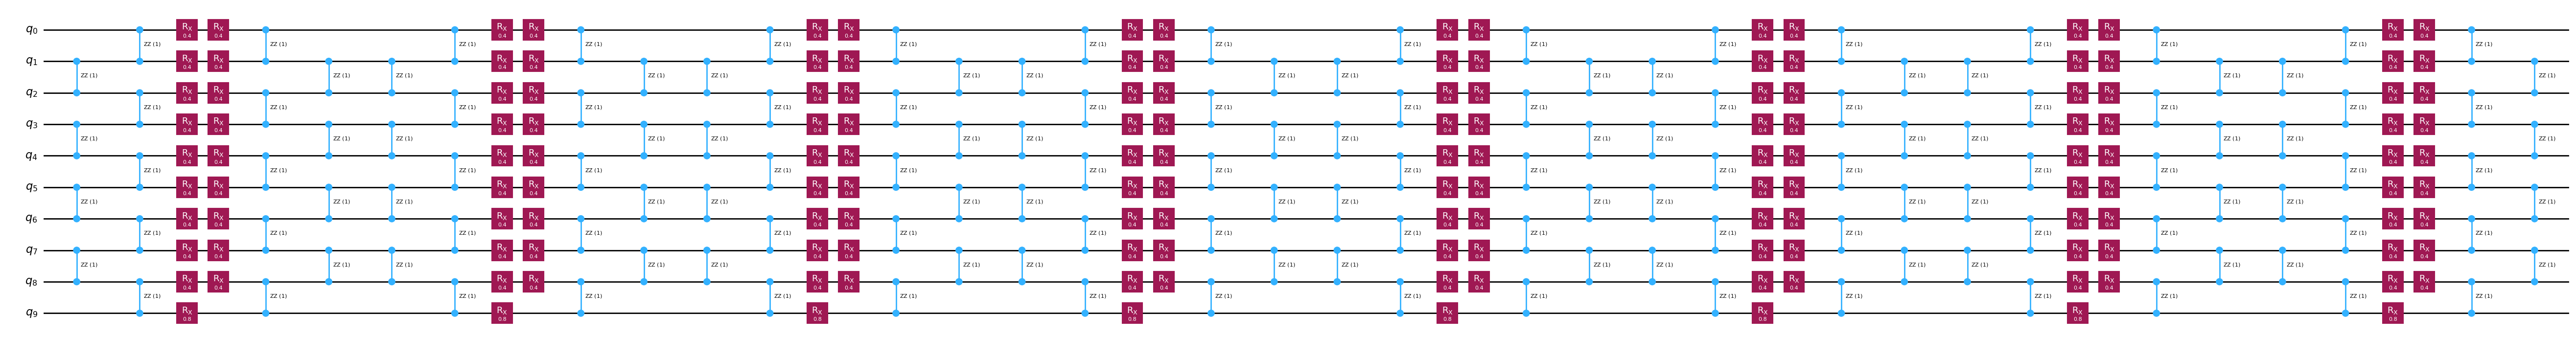

In [12]:
circuits[0].draw("mpl", fold=-1)

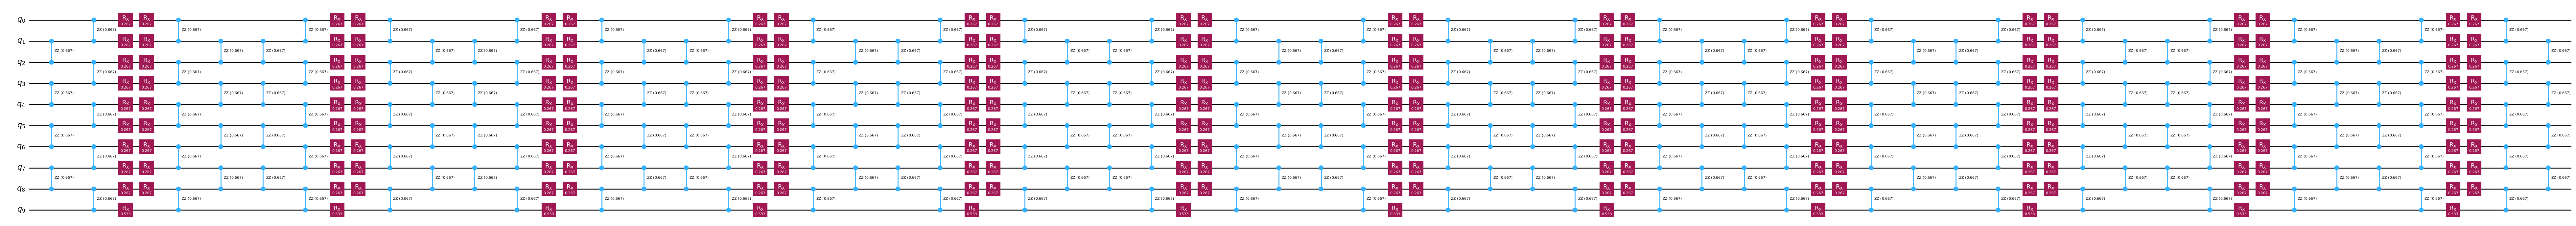

In [13]:
circuits[1].draw("mpl", fold=-1)

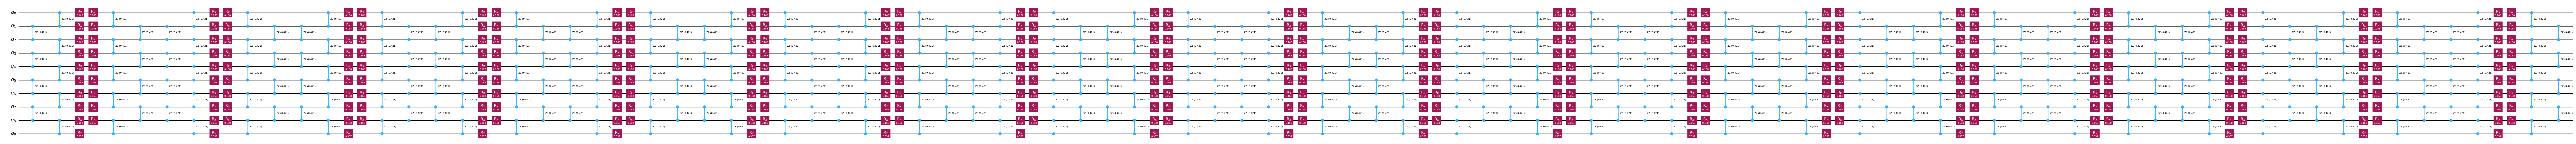

In [14]:
circuits[2].draw("mpl", fold=-1)

## Step 2: Optimize the problem

Normally, this is the step in the pattern during which you optimize your circuits for execution on hardware.
Here, since we only use a noiseless simulator, we simply transpile our circuit for a [GenericBackendV2](https://docs.quantum.ibm.com/api/qiskit/qiskit.providers.fake_provider.GenericBackendV2).

In [15]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import generate_preset_pass_manager

backend = GenericBackendV2(num_qubits=10)
transpiler = generate_preset_pass_manager(optimization_level=2, backend=backend)

transpiled_circuits = [transpiler.run(circ) for circ in circuits]

## Step 3: Execute quantum experiments

As explained in the very beginning, we will skip the optimization step 2 because we are simply going to compute our target observable's expectation values using a noise-free simulator, namely the [StatevectorEstimator](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorEstimator).

In [16]:
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()
job = estimator.run([(circ, observable) for circ in transpiled_circuits])
result = job.result()

## Step 4: Reconstruct results

First, we extract the individual expectation values obtained for each of the Trotter circuits:

In [17]:
evs = [res.data.evs for res in result]
print(evs)

[array(0.23799162), array(0.35754312), array(0.38649906)]


Next, we simply recombine them with our MPF coefficients to yield the total expectation values of the MPF. Below, we do so for each of the different ways by which we have computed $x$.

In [18]:
print("Analytical    solution:", evs @ coeffs_analytical)
print("Exact model   solution:", evs @ coeffs_exact.value)
print("Approx. model solution:", evs @ coeffs_approx.value)

Analytical    solution: 0.3954847855980006
Exact model   solution: 0.39548478559800204
Approx. model solution: 0.42991214253489807


Finally, for this small problem we can compute the exact reference value using [scipy.linalg.expm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.expm.html) as follows:

In [19]:
from scipy.linalg import expm

exp_H = expm(-1j * time * hamiltonian.to_matrix())

initial_state = np.zeros(exp_H.shape[0])
initial_state[0] = 1.0

time_evolved_state = exp_H @ initial_state

exact_obs = time_evolved_state.conj() @ observable.to_matrix() @ time_evolved_state
print(exact_obs.real)

0.40060242487899755


We can clearly see that the MPF has reduced the Trotter error compared to the one obtained with the deepest individual PF with $k_j=19$.
However, we also see that the approximate model is not flawless since it actually resulted in an expectation value that is worse than the exact solution. This shows the importance of using tight convergence criteria on the approximate model as you will learn in the guide [How to use the approximate model](https://qiskit.github.io/qiskit-addon-mpf/how_tos/using_approximate_model.html).